<a href="https://colab.research.google.com/github/namigabbasov/ai-literacy-bibliometric-analysis/blob/main/scripts/python_collaboration_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RQ2 — Knowledge Creation and Collaboration**

Who are the central and productive authors, communities, and countries in AI literacy research, and how do they collaborate?

## Setup: Install and Import Required Libraries

In [ ]:
resol=1000

In [1]:
!pip install -q python-louvain networkx matplotlib seaborn pandas numpy pycountry
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import re
import community as community_louvain  # python-louvain
import pycountry
from itertools import combinations
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import community.community_louvain as community_louvain

import re, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import combinations
import community.community_louvain as community_louvain
import seaborn as sns
sns.set(style="whitegrid")


##

## Load AI Literacy Dataset from GitHub

In [2]:
url = "https://raw.githubusercontent.com/namigabbasov/ai-literacy-bibliometric-analysis/refs/heads/main/data/ai_literacy.csv"
df = pd.read_csv(url, low_memory=False)

## Author Collaboration Network

##

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# ==========================================
# 1. CLEAN + PREPARE AUTHOR DATA
# ==========================================

dfA = df.copy()

# Ensure citation column numeric
dfA['Cited by'] = pd.to_numeric(dfA['Cited by'], errors='coerce').fillna(0)

# Function to split authors correctly from Scopus
def split_authors_cell(x):
    if pd.isna(x):
        return []
    parts = [p.strip() for p in str(x).split(';') if p.strip()]
    return parts

# Split authors into lists
dfA['author_list'] = dfA['Authors'].apply(split_authors_cell)

# Explode into one row per author
authors_exploded = dfA.explode('author_list').rename(columns={'author_list': 'author'})

# Convert to string and strip whitespace
authors_exploded['author'] = authors_exploded['author'].astype(str).str.strip()

# Remove invalid author names
invalid_authors = ["", "nan", "none", "null", "n.a."]
authors_exploded = authors_exploded[
    ~authors_exploded['author'].str.lower().isin(invalid_authors)
]

# Count publications
author_pub_counts = (
    authors_exploded['author']
        .value_counts()
        .rename_axis('author')
        .reset_index(name='n_pubs')
)

# Select Top 10 authors
TOP_N = 10
top_authors = author_pub_counts.head(TOP_N)

# ==========================================
# 2. PLOT — Top 10 Authors by Publications
# ==========================================

plt.figure(figsize=(10, 6), dpi=resol)

# Sort values explicitly highest → lowest
top_authors_sorted = top_authors.sort_values("n_pubs", ascending=False)

# Wrap long author names
labels = [textwrap.fill(a, 30) for a in top_authors_sorted['author']]
values = top_authors_sorted['n_pubs'].values

plt.barh(labels, values, color="gray", edgecolor="black", linewidth=0.9)

# Highest bar at the top
plt.gca().invert_yaxis()

plt.title("Top 10 Authors by Number of Publications", fontsize=16, fontweight='bold')
plt.xlabel("Number of Publications", fontsize=14)
plt.ylabel("Author", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=11)

# Give room for labels
plt.subplots_adjust(left=0.30)

plt.tight_layout()
plt.show()


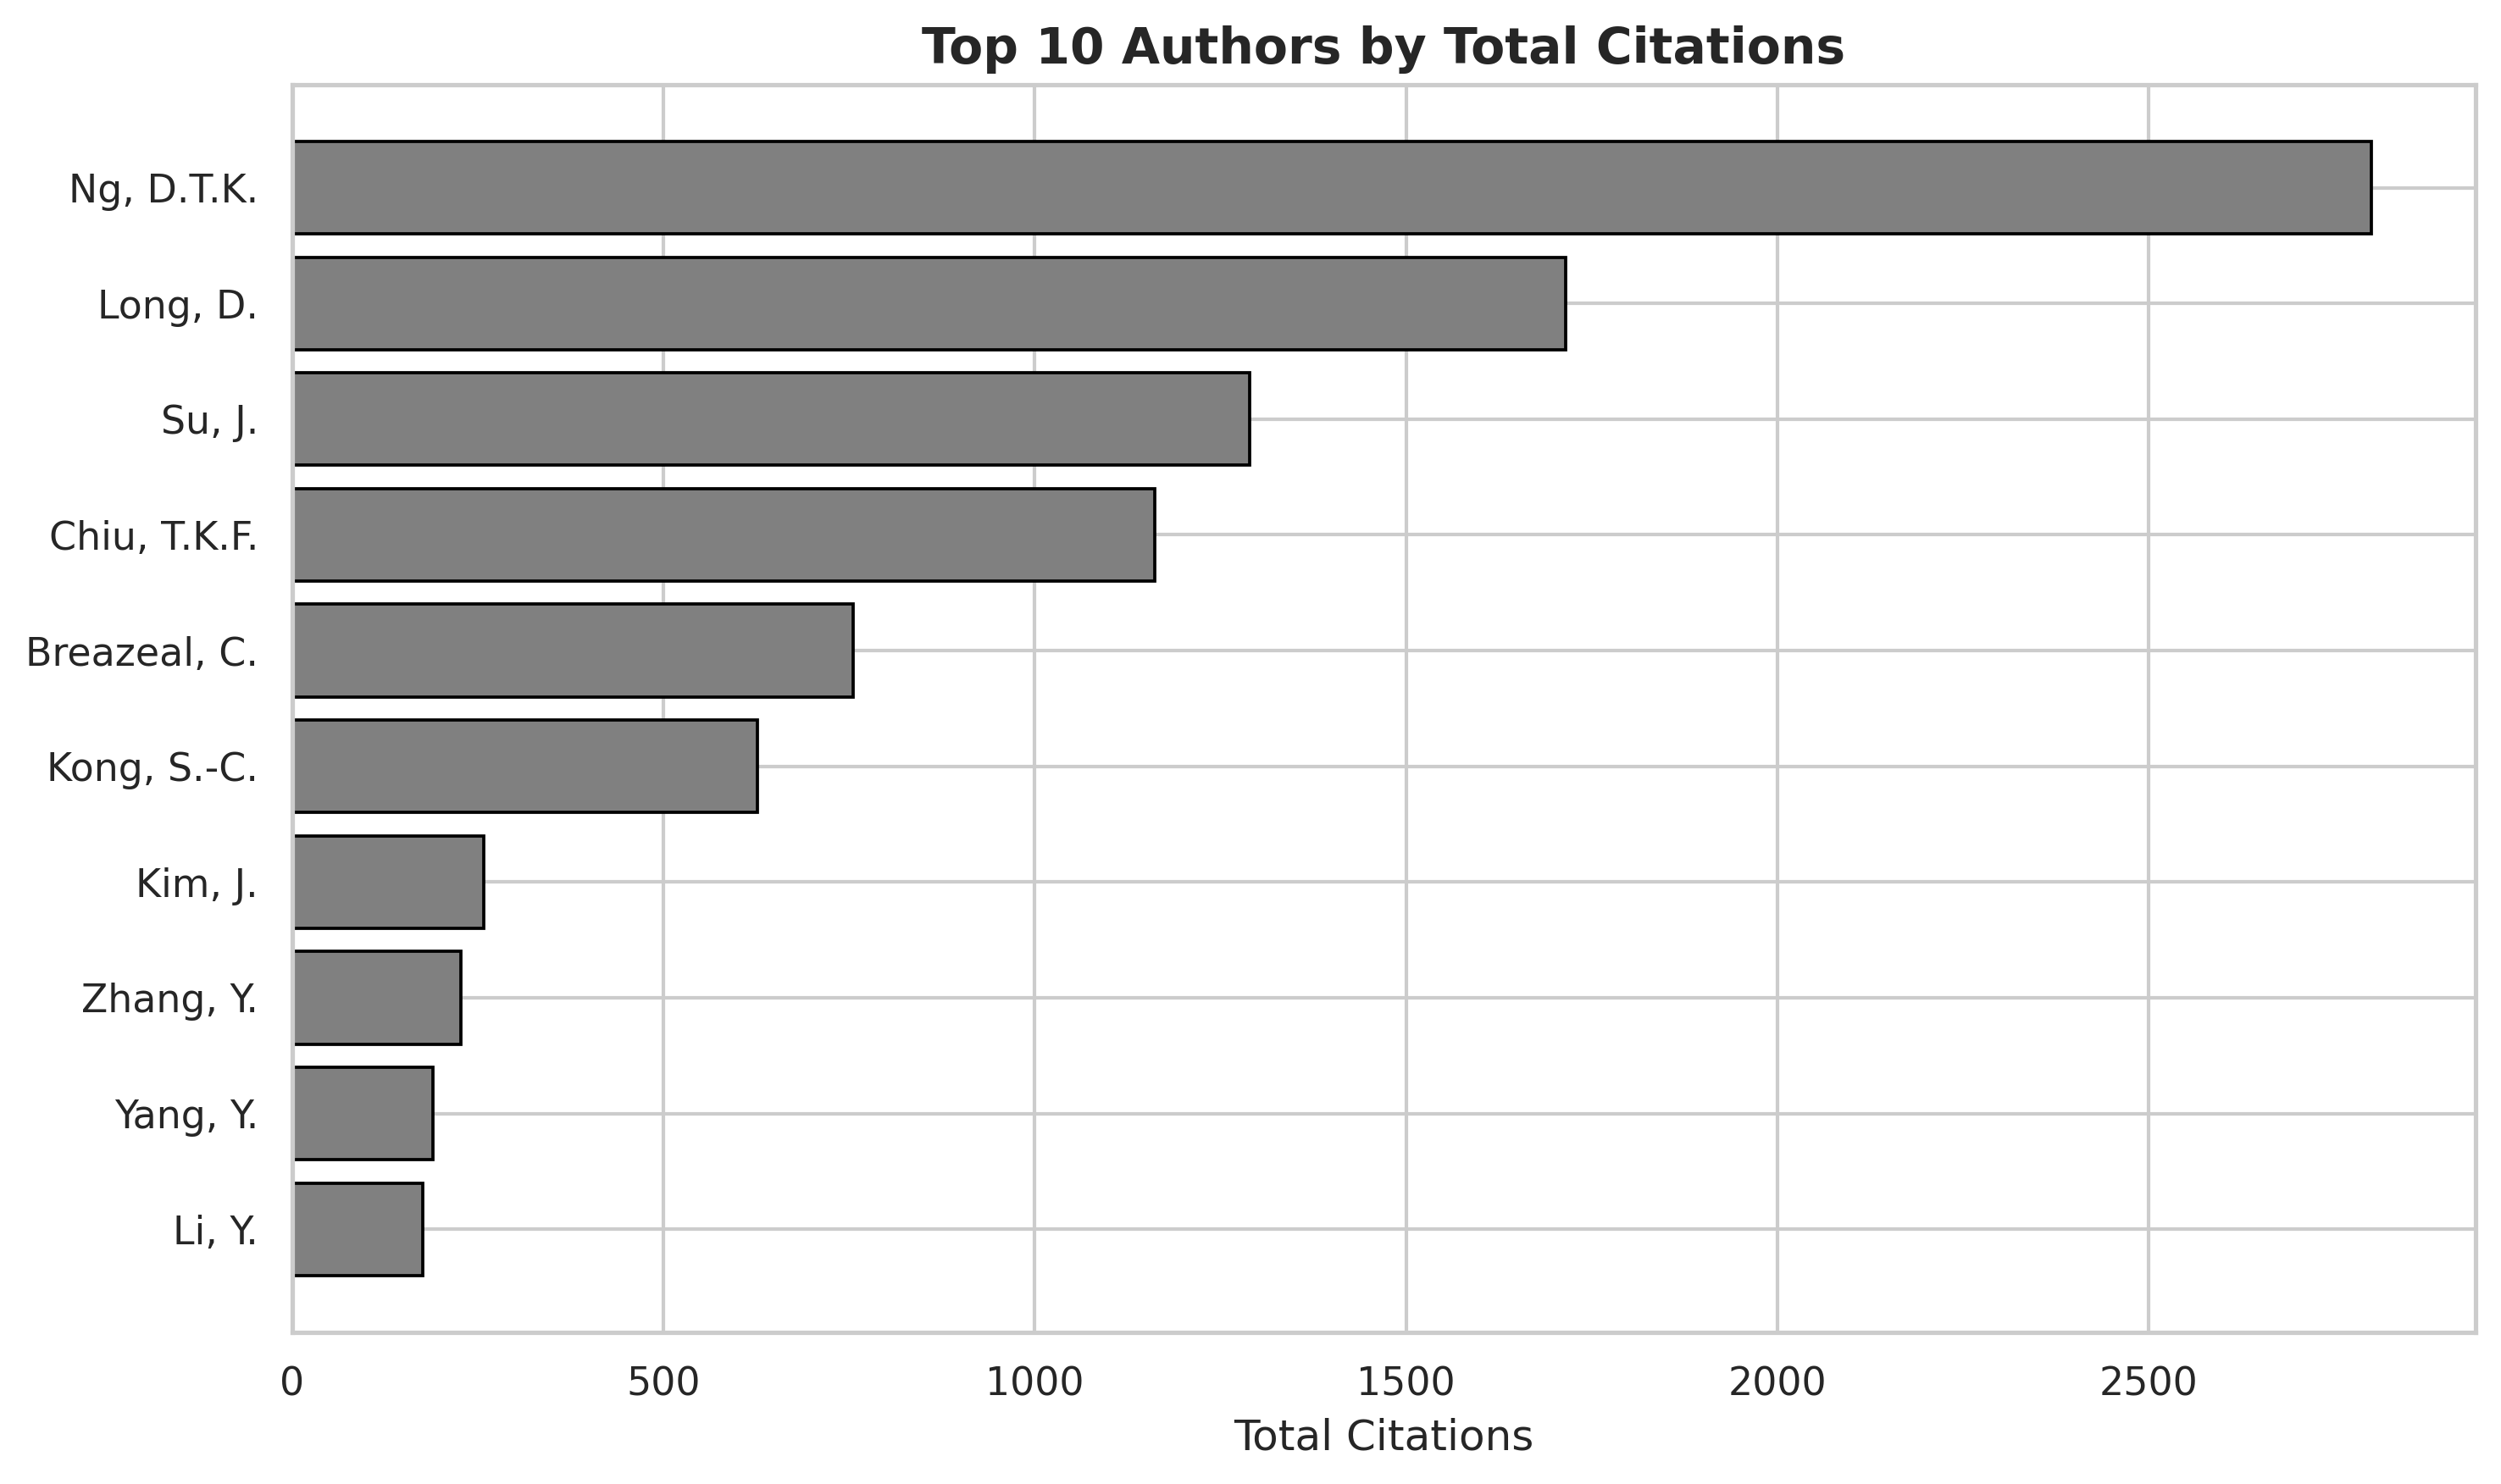

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# ================================
# 1. CLEAN + PREPARE DATA
# ================================

dfA = df.copy()

# Ensure citation column numeric
dfA['Cited by'] = pd.to_numeric(dfA['Cited by'], errors='coerce').fillna(0)

# Split authors safely
def split_authors(x):
    if pd.isna(x):
        return []
    return [a.strip() for a in str(x).split(';') if a.strip()]

dfA['author_list'] = dfA['Authors'].apply(split_authors)

# Explode into 1 row per author
authors_exploded = dfA.explode('author_list').rename(columns={'author_list':'author'})
authors_exploded['author'] = authors_exploded['author'].astype(str).str.strip()

# Remove invalid names
invalid = ["", "nan", "none", "null", "n.a."]
authors_exploded = authors_exploded[~authors_exploded['author'].str.lower().isin(invalid)]

# ================================
# 2. BUILD TOP AUTHORS TABLE
# ================================

# TOP_N authors by publication count
TOP_N = 10

author_pub_counts = (
    authors_exploded['author']
    .value_counts()
    .rename_axis('author')
    .reset_index(name='n_pubs')
)

top_authors = author_pub_counts.head(TOP_N)['author'].tolist()

# Author-level citation summary
author_citation_summary = (
    authors_exploded.groupby('author', as_index=False)
    .agg(
        n_pubs=('Cited by','count'),
        total_citations=('Cited by','sum'),
        mean_citations=('Cited by','mean')
    )
)

# Filter to top authors and sort by total citations
top_authors_by_cites = (
    author_citation_summary[author_citation_summary['author'].isin(top_authors)]
    .sort_values('total_citations', ascending=False)
)

# ================================
# 3. PLOT — Top Authors by Total Citations
# ================================

FIG_DPI = 300
OUT_PREFIX = "RQ2_"

plt.figure(figsize=(10,6), dpi=resol)

# Sort for clean plotting
top_cite_sorted = top_authors_by_cites.sort_values("total_citations", ascending=False)

labels = [textwrap.fill(a, 35) for a in top_cite_sorted['author']]
values = top_cite_sorted['total_citations'].values

plt.barh(labels, values, color='gray', edgecolor='black', linewidth=0.9)

# Highest at top
plt.gca().invert_yaxis()

plt.title(f"Top {TOP_N} Authors by Total Citations", fontsize=14, weight='bold')
plt.xlabel("Total Citations", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.subplots_adjust(left=0.30)
plt.tight_layout()

plt.savefig(f"{OUT_PREFIX}top_authors_total_citations.png", bbox_inches='tight')
plt.show()



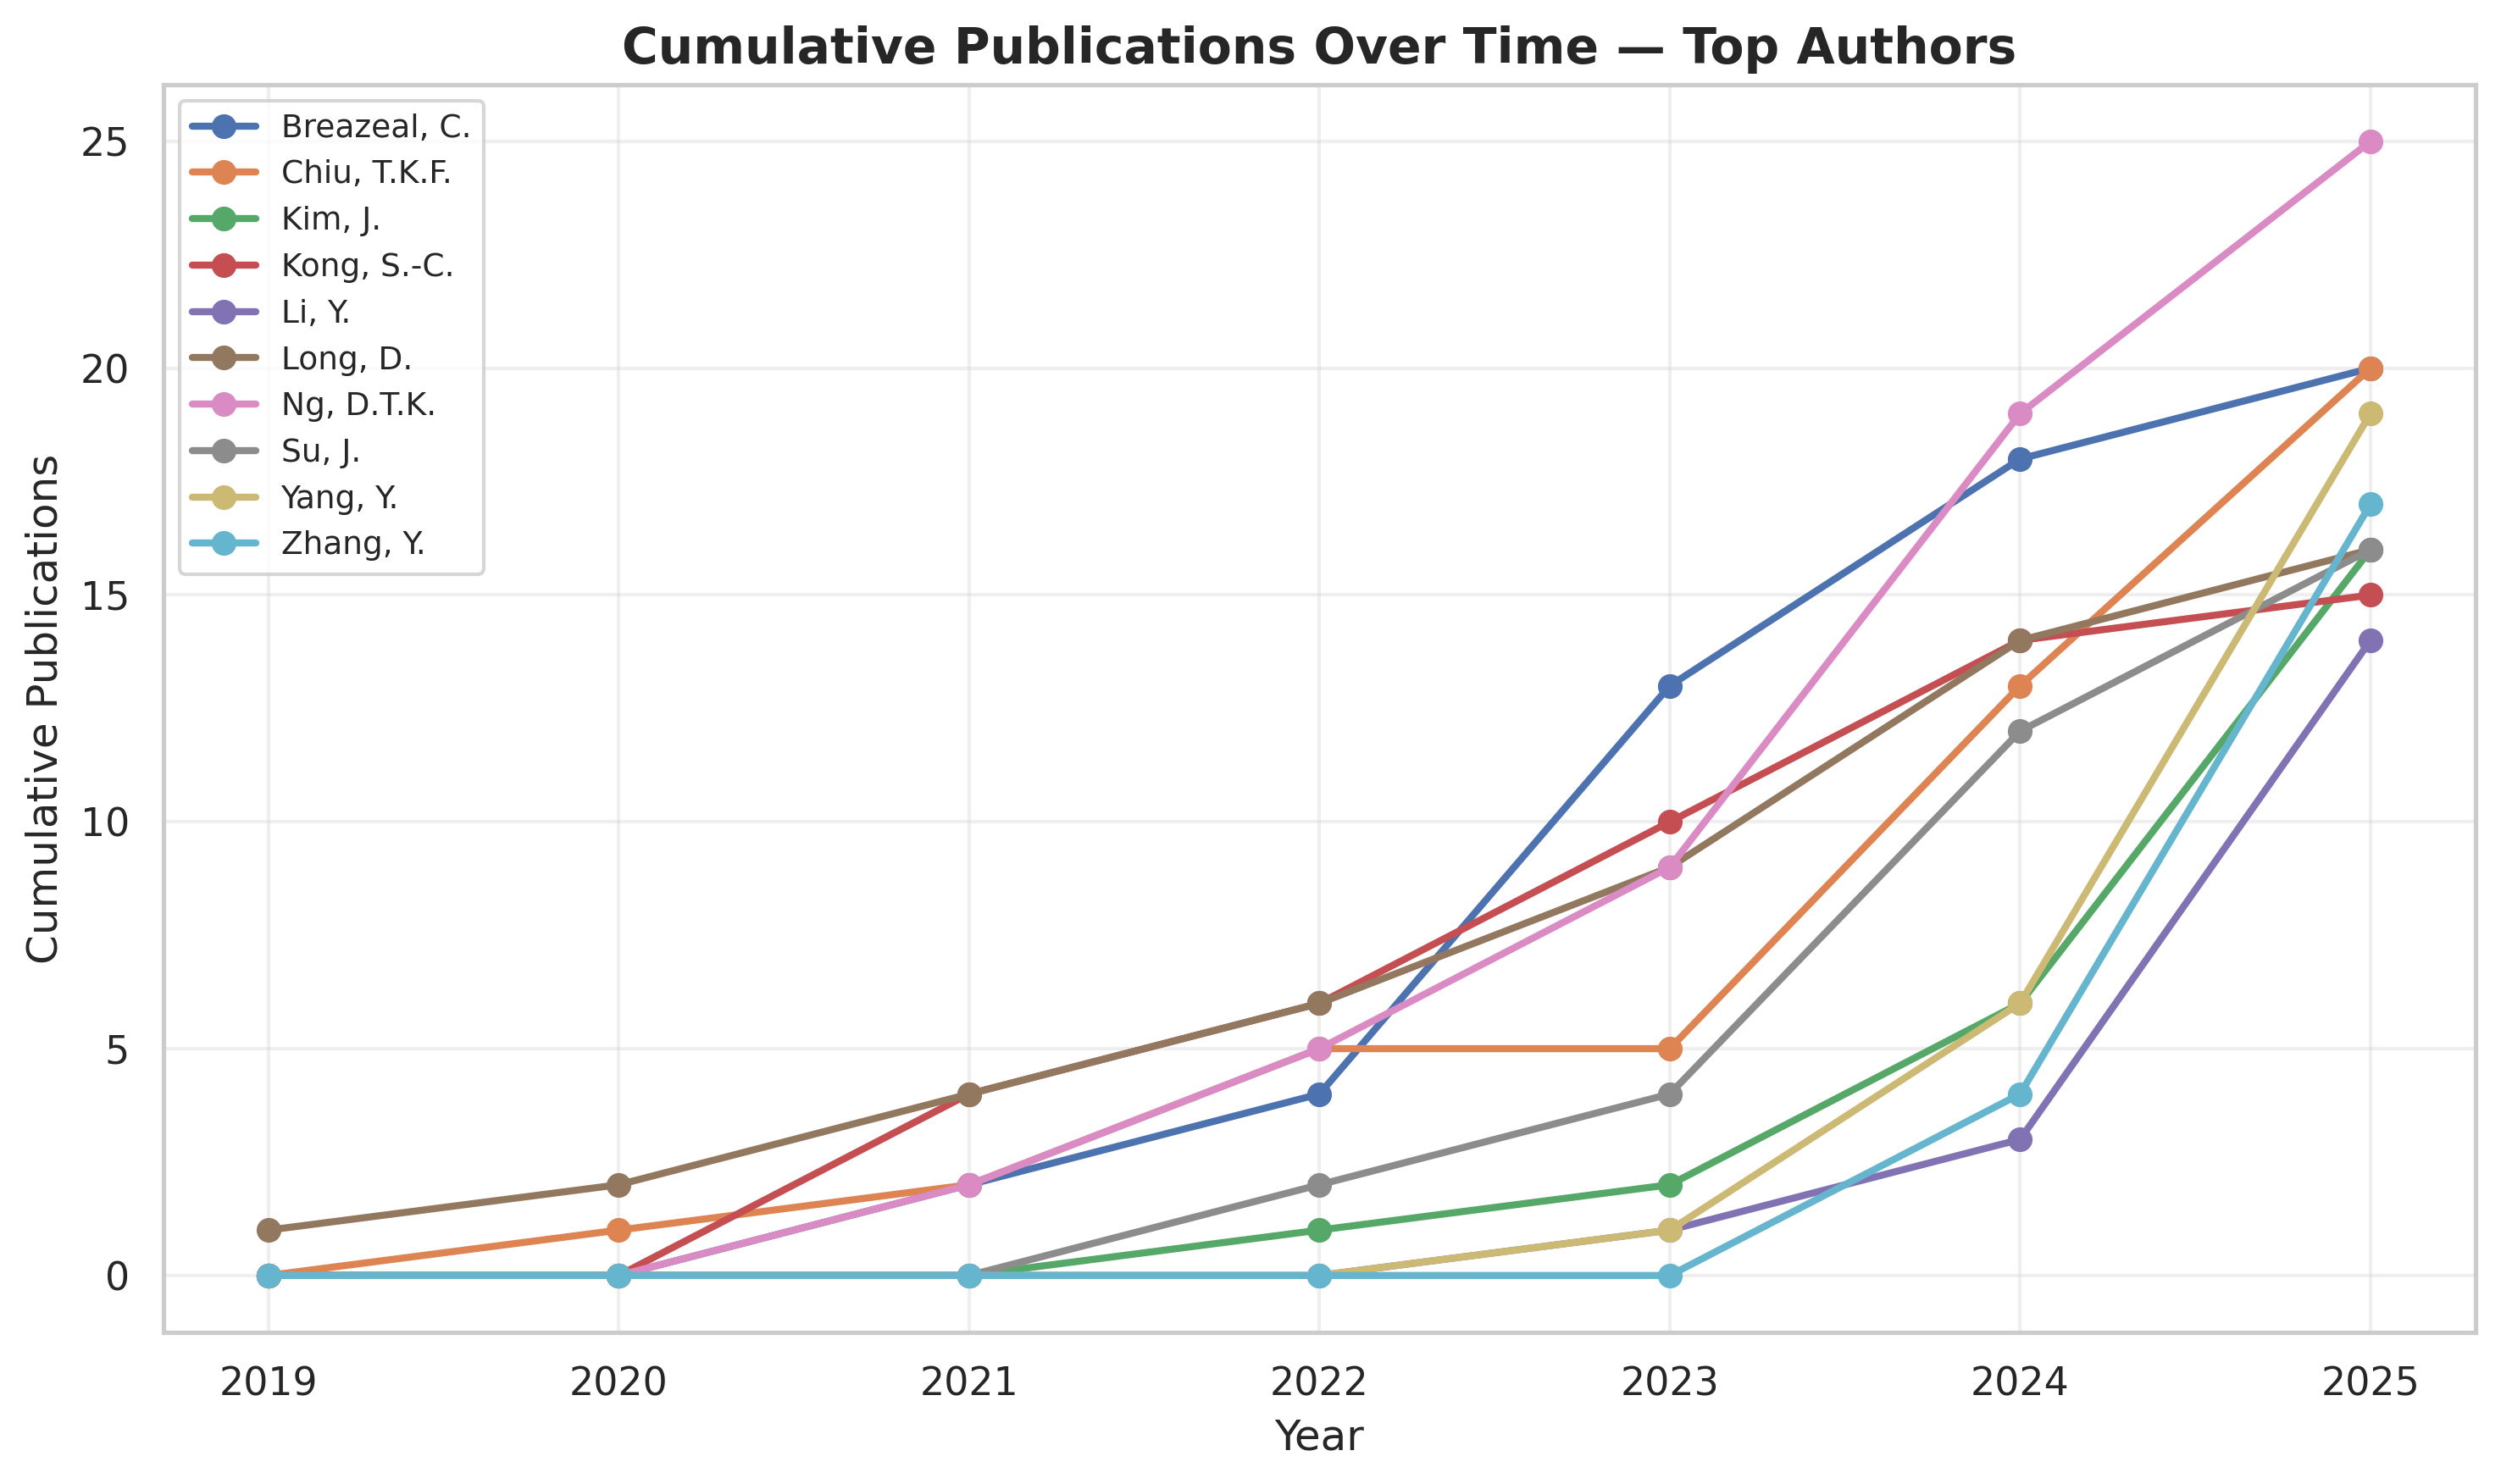

In [5]:
# ================================
# PLOT C — Cumulative Publications Over Time (Top Authors)
# ================================

dfA = df.copy()

# Clean year
dfA['Year'] = pd.to_numeric(dfA['Year'], errors='coerce')

# Split authors
def split_authors(x):
    if pd.isna(x):
        return []
    return [a.strip() for a in str(x).split(';') if a.strip()]

dfA['author_list'] = dfA['Authors'].apply(split_authors)

# Explode
author_year = dfA[['Year','author_list']].explode('author_list')
author_year['author'] = author_year['author_list'].astype(str).str.strip()

# Remove invalid authors
invalid = ["", "nan", "none", "null", "n.a."]
author_year = author_year[~author_year['author'].str.lower().isin(invalid)]

# Pick top authors (from earlier step)
# IMPORTANT FIX:
topN_list = top_authors          # <--- this fixes your error

# Count publications per author per year
author_year_counts = (
    author_year.groupby(['author','Year'])
               .size()
               .reset_index(name='count')
)

# Keep only top authors
plot_df = author_year_counts[author_year_counts['author'].isin(topN_list)]

# Pivot to wide format
pivot = plot_df.pivot_table(
    index='Year',
    columns='author',
    values='count',
    fill_value=0
).sort_index()

# Cumulative publications per author
pivot_cum = pivot.cumsum()

# Plot
plt.figure(figsize=(10,6), dpi=resol)

for col in pivot_cum.columns:
    plt.plot(
        pivot_cum.index,
        pivot_cum[col],
        marker='o',
        linewidth=2,
        label=col
    )

plt.title("Cumulative Publications Over Time — Top Authors", fontsize=14, weight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Cumulative Publications", fontsize=12)

plt.legend(loc='upper left', fontsize=9)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


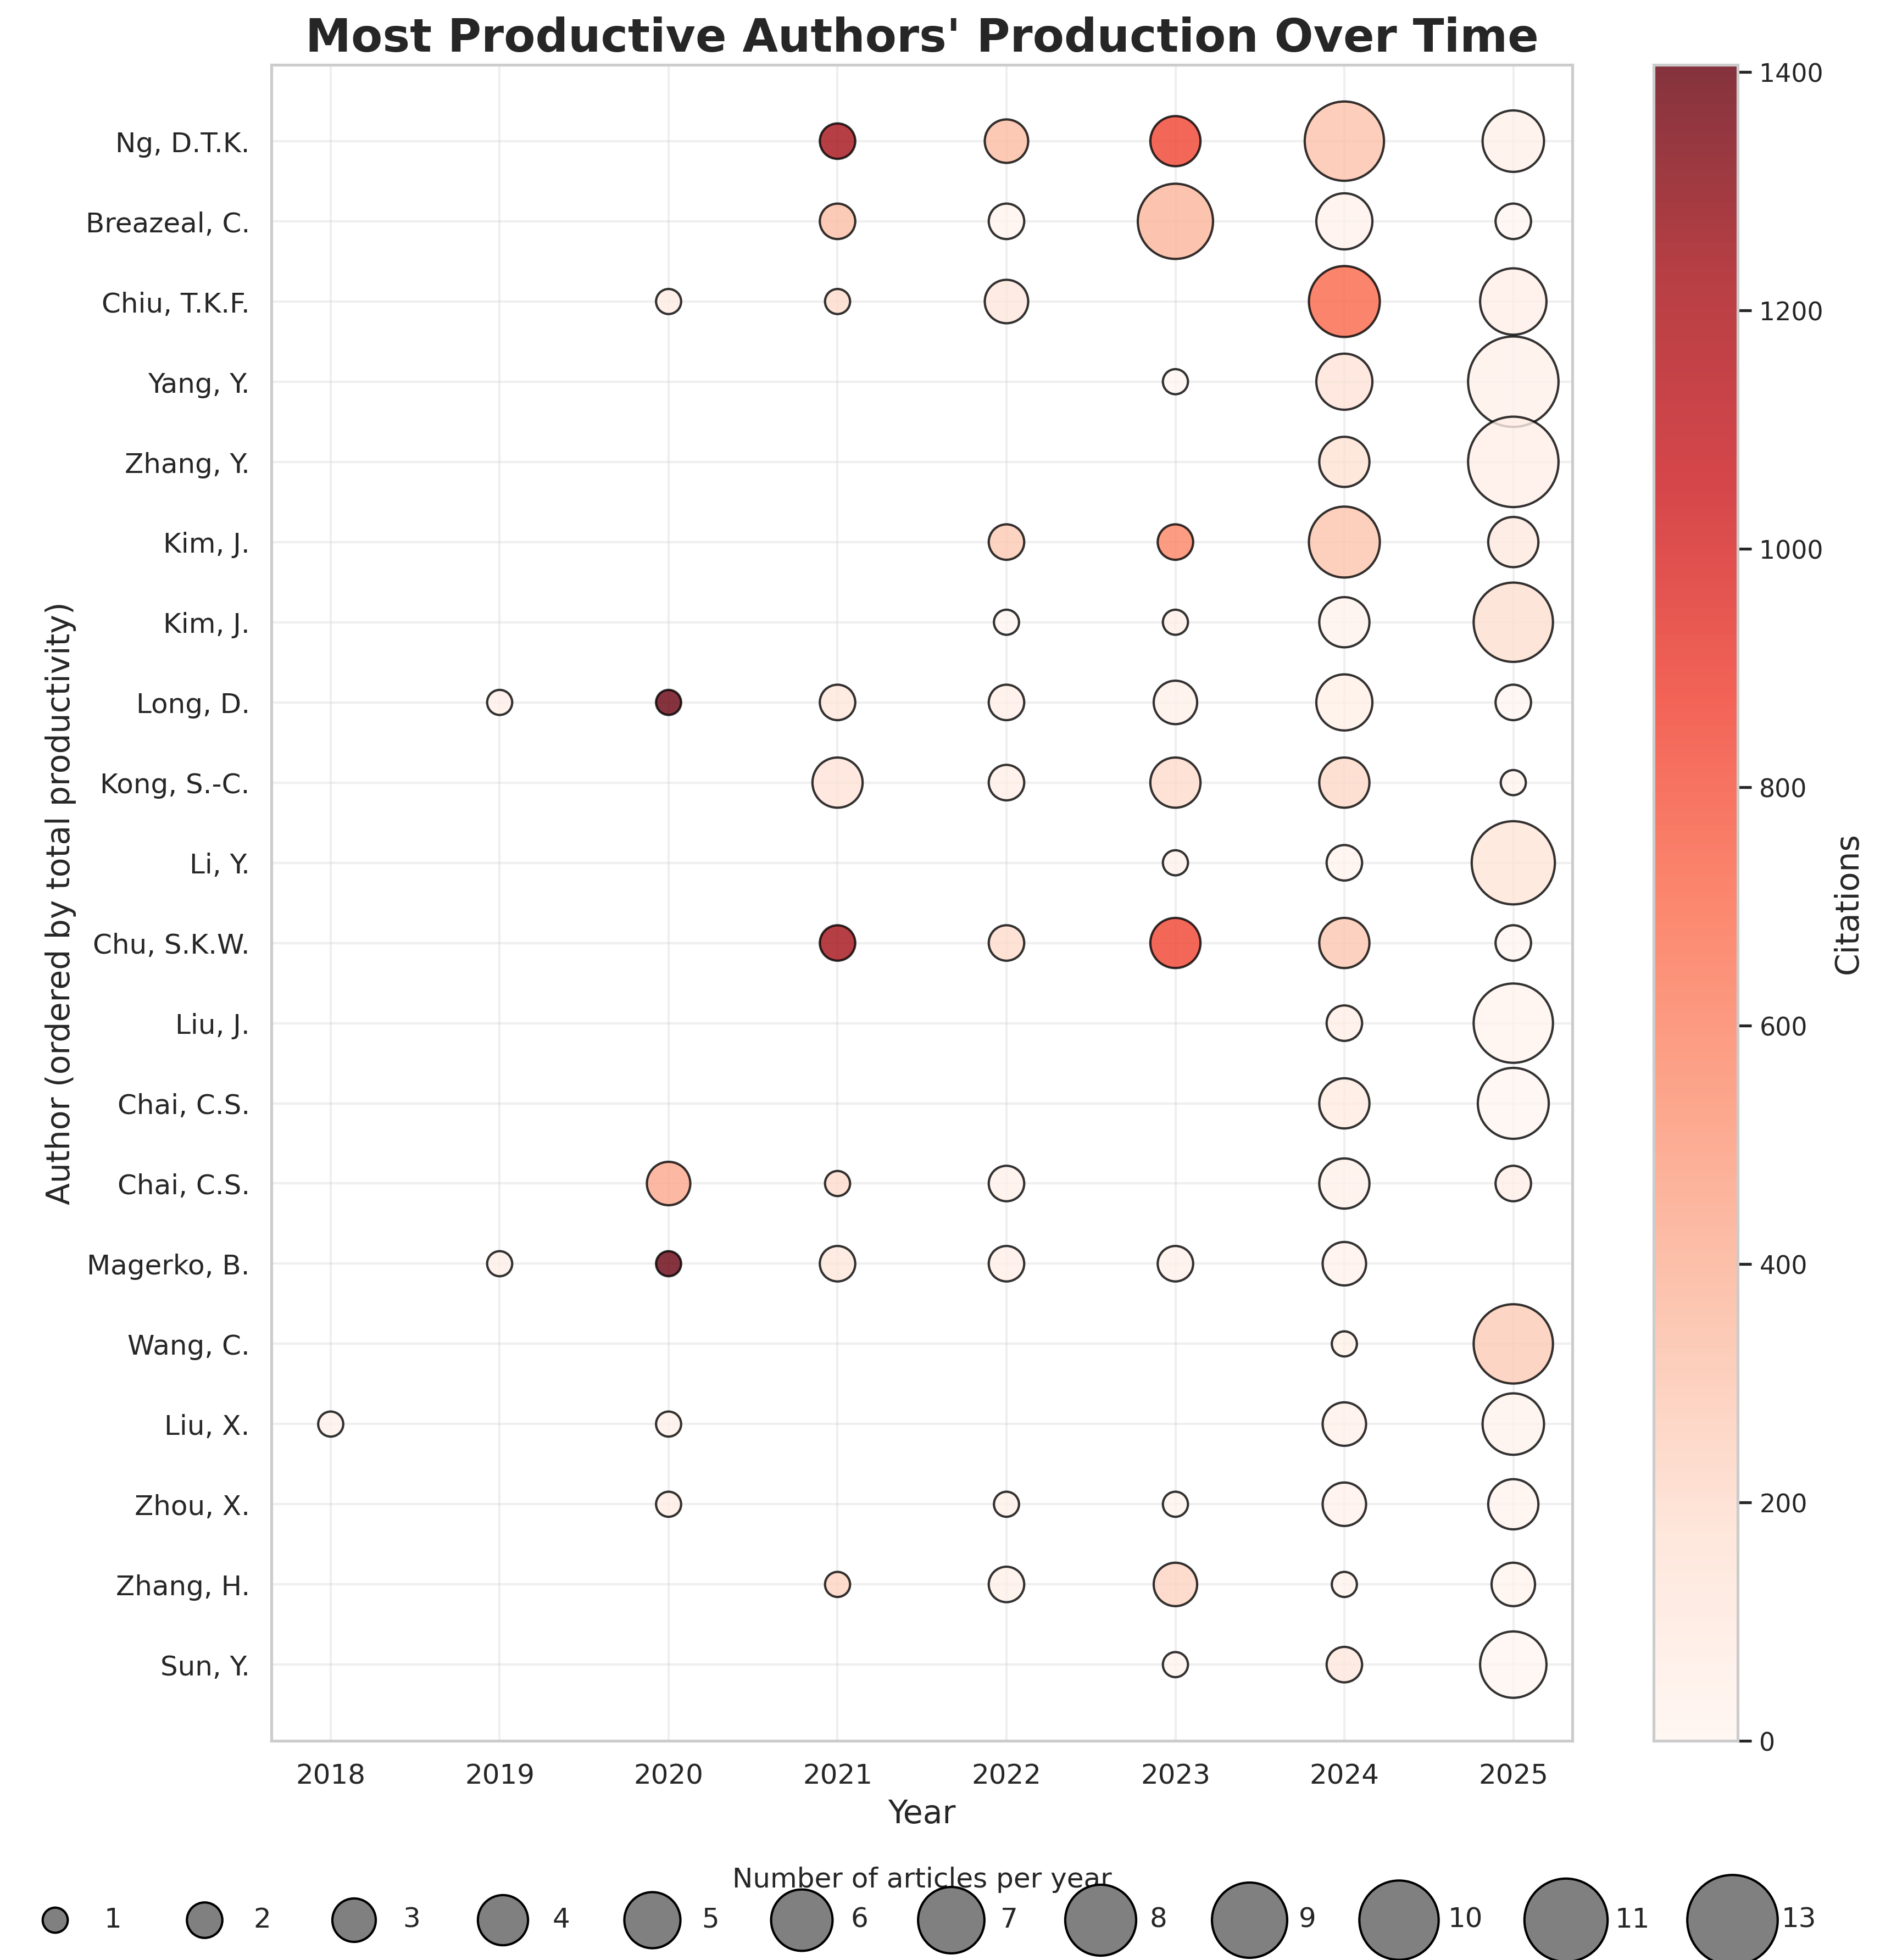

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textwrap

# ====================================
# 1. PREPARE CLEAN AUTHOR/YEAR DATA
# ====================================

dfR = df.copy()

# Clean citations and year
dfR['Cited by'] = pd.to_numeric(dfR['Cited by'], errors='coerce').fillna(0)
dfR['Year'] = pd.to_numeric(dfR['Year'], errors='coerce')

# Split authors
def split_authors(x):
    if pd.isna(x):
        return []
    return [a.strip() for a in str(x).split(';') if a.strip()]

dfR['author_list'] = dfR['Authors'].apply(split_authors)

# Explode into one row per author per paper
exploded = dfR.explode('author_list').rename(columns={'author_list':'author'})
exploded['author'] = exploded['author'].astype(str).str.strip()

# Remove invalid author names
invalid_authors = ["", "nan", "none", "null", "n.a."]
exploded = exploded[~exploded['author'].str.lower().isin(invalid_authors)]

# Count total productivity of each author
author_productivity = exploded['author'].value_counts()

# Select top 20 authors
TOP_N = 20
top_authors = list(author_productivity.head(TOP_N).index)

exp_top = exploded[exploded['author'].isin(top_authors)]


# ====================================
# 2. BUILD AUTHOR–YEAR TABLE
# ====================================

# Count publications per author per year
count_table = (
    exp_top.groupby(['author','Year'])
           .size()
           .reset_index(name='n_pubs')
)

# Sum citations per author per year
cite_table = (
    exp_top.groupby(['author','Year'])['Cited by']
           .sum()
           .reset_index(name='total_cites')
)

# Merge counts + citations
merged = pd.merge(count_table, cite_table, on=['author','Year'], how='left')


# ====================================
# 3. ORDER AUTHORS (BEST AT TOP)
# ====================================

# Sort from MOST productive → least productive,
# then REVERSE list so most productive plots at TOP for scatter
author_order = (
    author_productivity.loc[top_authors]
    .sort_values(ascending=False)
    .index
    .tolist()[::-1]     # <<< KEY FIX: reverse the list
)

# Map each author to a numeric y-position
author_to_y = {author: i for i, author in enumerate(author_order)}
merged['y'] = merged['author'].map(author_to_y)

# Add spacing so lines don't overlap
spacing_factor = 1.3
merged['y_spaced'] = merged['y'] * spacing_factor


# ====================================
# 4. BUBBLE SIZE SCALING
# ====================================

SIZE_SCALE = 120
merged['size'] = merged['n_pubs'] * SIZE_SCALE


# ====================================
# 5. PLOT SETTINGS
# ====================================

FIG_WIDTH = 12
FIG_HEIGHT = 12
TEXT_SIZE = 14
LABEL_SIZE = 12
TITLE_SIZE = 20
LEGEND_SIZE = 12

plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=resol)


# ====================================
# 6. MAIN SCATTER PLOT
# ====================================

plt.scatter(
    merged['Year'],
    merged['y_spaced'],
    s=merged['size'],
    c=merged['total_cites'],
    cmap='Reds',        # use 'Greys' for grayscale
    alpha=0.8,
    edgecolor='black'
)


# ====================================
# 7. FIXED: CORRECT Y-AXIS ORDERING
# ====================================

sorted_y = sorted(merged['y_spaced'].unique())
y_labels = [author_order[int(y/spacing_factor)] for y in sorted_y]

plt.yticks(
    sorted_y,
    [textwrap.fill(a, 40) for a in y_labels],
    fontsize=LABEL_SIZE
)


# ====================================
# 8. AXIS LABELS & TITLE
# ====================================

plt.xticks(sorted(merged['Year'].unique()), fontsize=LABEL_SIZE)
plt.xlabel("Year", fontsize=TEXT_SIZE)
plt.ylabel("Author (ordered by total productivity)", fontsize=TEXT_SIZE)

plt.title("Most Productive Authors' Production Over Time",
          fontsize=TITLE_SIZE, fontweight='bold')

plt.grid(alpha=0.3)


# ====================================
# 9. COLORBAR (CITATIONS)
# ====================================

cbar = plt.colorbar()
cbar.set_label("Citations", fontsize=TEXT_SIZE)


# ====================================
# 10. FULL BUBBLE SIZE LEGEND (1–13)
# ====================================

unique_pubs = sorted(merged['n_pubs'].unique())   # e.g., [1..13]

size_legend_handles = []
for p in unique_pubs:
    size_legend_handles.append(
        plt.scatter([], [],
                    s=p * SIZE_SCALE,
                    color='gray',
                    edgecolor='black',
                    label=str(p))     # only the number
    )

plt.legend(
    handles=size_legend_handles,
    title="Number of articles per year",
    scatterpoints=1,
    fontsize=LEGEND_SIZE,
    title_fontsize=LEGEND_SIZE,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.06),
    ncol=len(unique_pubs),     # 13 circles in one row
    frameon=False
)

plt.tight_layout()
plt.show()
